# Rare Event Prediction: Resampling Experiments

This notebook evaluates different resampling strategies using the same Elastic Net logistic regression model. All experiments use the same dataset, features, and model configuration for comparability.

## 1. Setup
Common imports and dataset loading.

In [321]:
# pip install imbalanced-learn

In [504]:
# Imports
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Resampling Methods
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, ClusterCentroids
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.ensemble import BalancedBaggingClassifier

In [506]:
# Load and preprocess
df = pd.read_csv("synth_rare_event_data.csv")
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
target_col = "rare_event"

df = df.dropna(subset=[target_col])
X = df.drop(columns=[target_col])
y = df[target_col]

for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=1
)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_raw), columns=X.columns)

mi = mutual_info_classif(X_train_scaled, y_train)
top_features = pd.Series(mi, index=X.columns).sort_values(ascending=False).head(15).index.tolist()

X_train = X_train_scaled[top_features]
X_test = X_test_scaled[top_features]

In [508]:
# Define ElasticNet model (used consistently across all experiments)
def make_model():
    return LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=0.5,
        C=1.0,
        max_iter=2000,
        tol=1e-4,
        class_weight='balanced',
        random_state=1
    )

def evaluate_model(model, X_test, y_test, label=""):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)

    # Store results
    results.append({
        "Method": label,
        "ROC AUC": roc,
        "PR AUC": pr_auc
    })

    # Print and plot
    print(f"--- {label} ---")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", round(roc, 3))
    print("PR AUC:", round(pr_auc, 3))
    plt.plot(recall, precision, label=f"{label} (PR AUC = {pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Event", "Rare Event"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix: {label}")
    plt.grid(False)
    plt.show()

In [510]:
# Store evaluation results here
results = []

## Experiment 1: Manual Upsampling

--- Manual Upsampling ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.03      0.61      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.60      0.39      1000
weighted avg       0.97      0.59      0.72      1000

ROC AUC: 0.653
PR AUC: 0.035


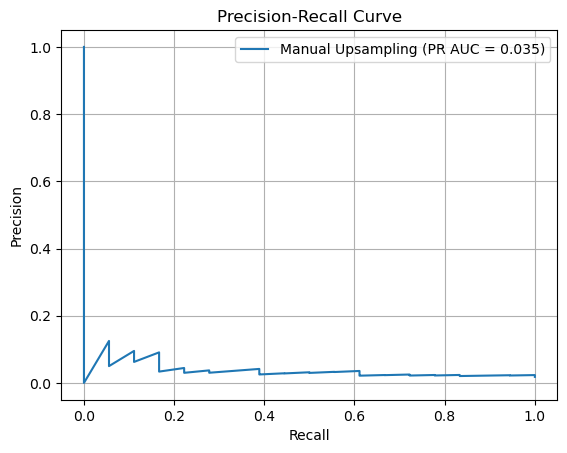

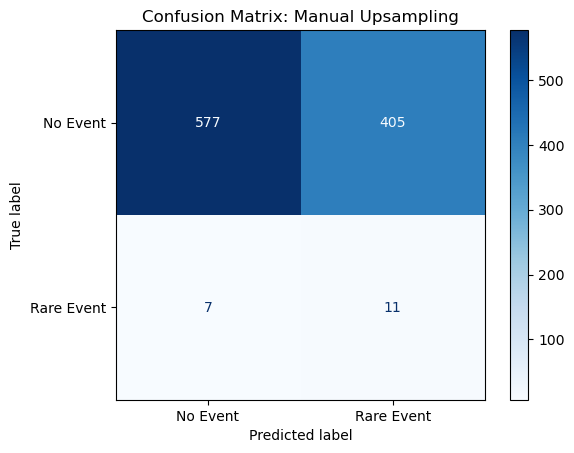

In [513]:
# Manual Upsampling
train_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
minority = train_df[train_df[target_col] == 1]
majority = train_df[train_df[target_col] == 0]

minority_upsampled = resample(
    minority, replace=True, n_samples=len(majority), random_state=42
)
upsampled_train = pd.concat([majority, minority_upsampled])

X_manual = upsampled_train.drop(columns=[target_col])
y_manual = upsampled_train[target_col]

model = make_model()
model.fit(X_manual, y_manual)
evaluate_model(model, X_test, y_test, label="Manual Upsampling")

In [515]:
model_manual = model

## Experiment 2: SMOTE

--- SMOTE ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.03      0.61      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.60      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.632
PR AUC: 0.029


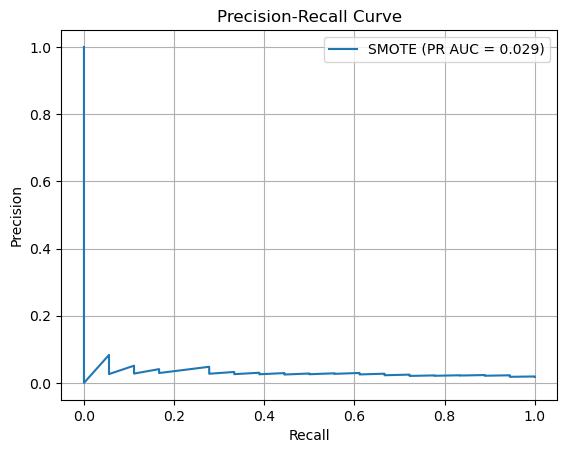

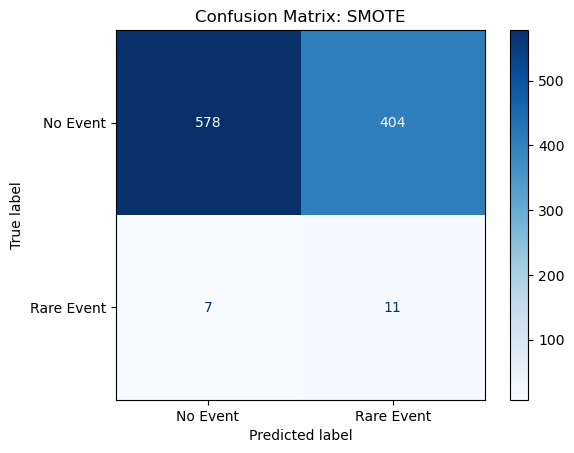

In [518]:
# SMOTE
X_res, y_res = SMOTE(random_state=42).fit_resample(X_train, y_train)
model = make_model()
model.fit(X_res, y_res)
evaluate_model(model, X_test, y_test, label="SMOTE")

In [520]:
model_smote = model

## Experiment 3: SMOTE + Tomek Links

--- SMOTETomek ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.03      0.61      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.60      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.632
PR AUC: 0.029


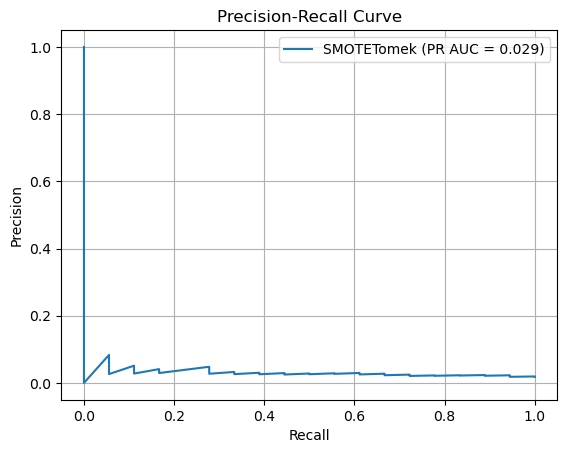

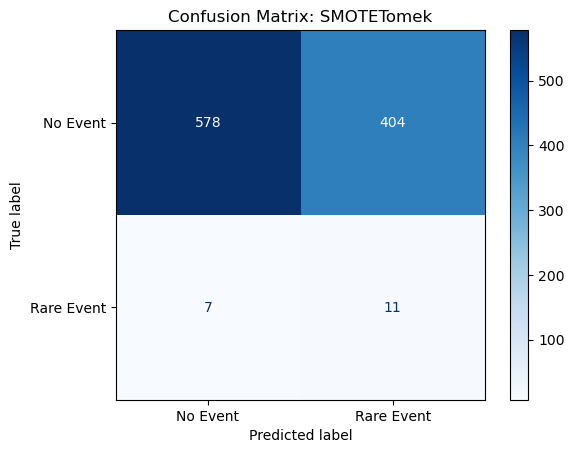

In [523]:
# SMOTETomek
X_res, y_res = SMOTETomek(random_state=42).fit_resample(X_train, y_train)
model = make_model()
model.fit(X_res, y_res)
evaluate_model(model, X_test, y_test, label="SMOTETomek")

In [524]:
model_tomek = model

## Experiment 4: No Resampling

--- No Resampling ---
              precision    recall  f1-score   support

           0       0.99      0.62      0.76       982
           1       0.02      0.50      0.04        18

    accuracy                           0.62      1000
   macro avg       0.50      0.56      0.40      1000
weighted avg       0.97      0.62      0.75      1000

ROC AUC: 0.598
PR AUC: 0.032


/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


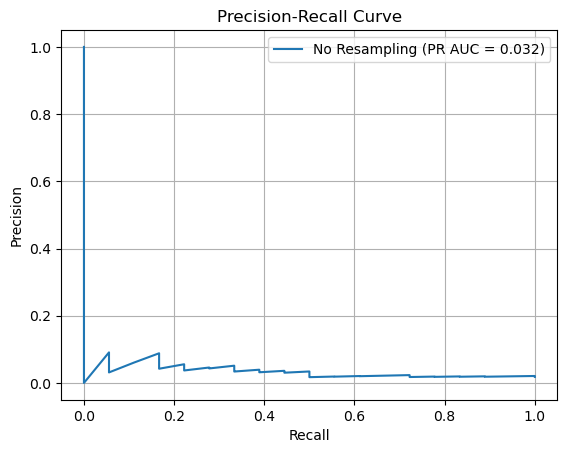

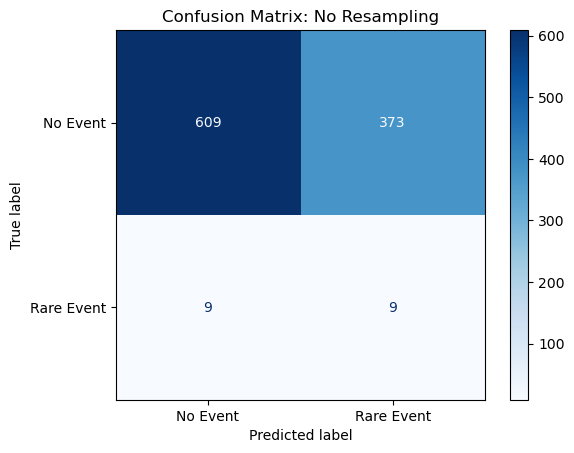

In [528]:
# No Resampling (baseline)
model = make_model()
model.fit(X_train, y_train)
evaluate_model(model, X_test, y_test, label="No Resampling")

In [529]:
model_baseline = model

## Experiment 5: ADASYN

--- ADASYN ---
              precision    recall  f1-score   support

           0       0.98      0.58      0.73       982
           1       0.02      0.50      0.04        18

    accuracy                           0.58      1000
   macro avg       0.50      0.54      0.39      1000
weighted avg       0.97      0.58      0.72      1000

ROC AUC: 0.617
PR AUC: 0.03


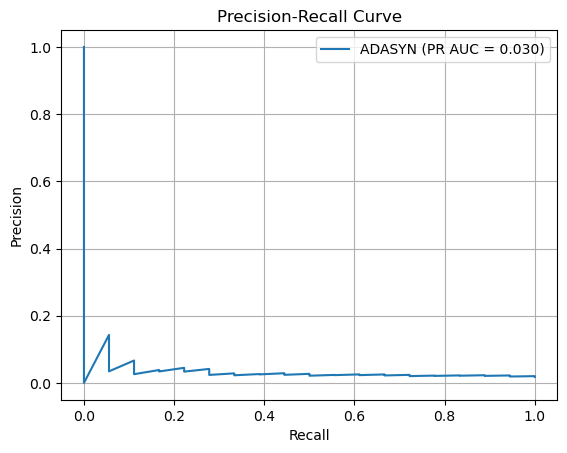

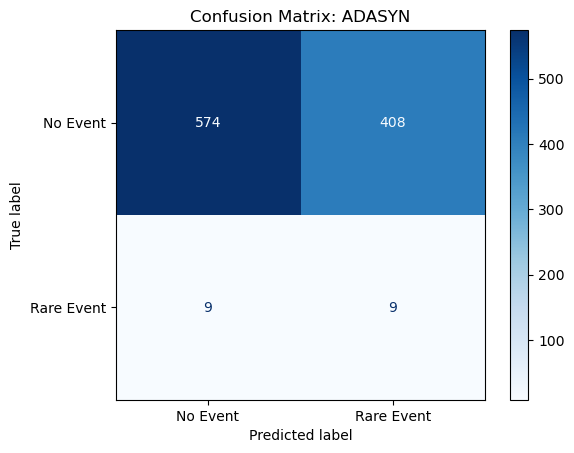

In [531]:
# ADASYN
X_res, y_res = ADASYN(random_state=42).fit_resample(X_train, y_train)
model = make_model()
model.fit(X_res, y_res)
evaluate_model(model, X_test, y_test, label="ADASYN")

In [532]:
model_adasyn = model

## Experiment 6: Borderline-SMOTE

--- Borderline SMOTE ---
              precision    recall  f1-score   support

           0       0.99      0.68      0.80       982
           1       0.02      0.44      0.05        18

    accuracy                           0.67      1000
   macro avg       0.50      0.56      0.42      1000
weighted avg       0.97      0.67      0.79      1000

ROC AUC: 0.579
PR AUC: 0.026


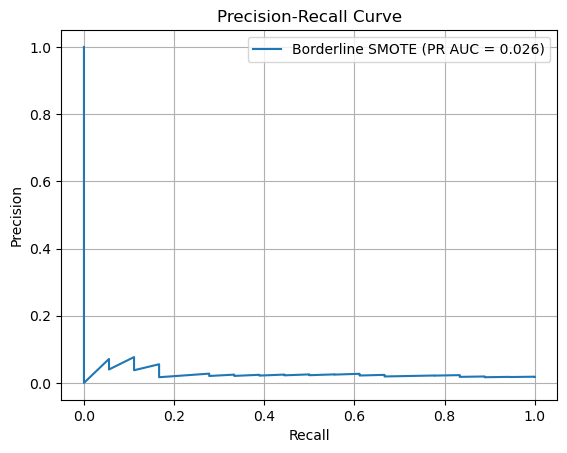

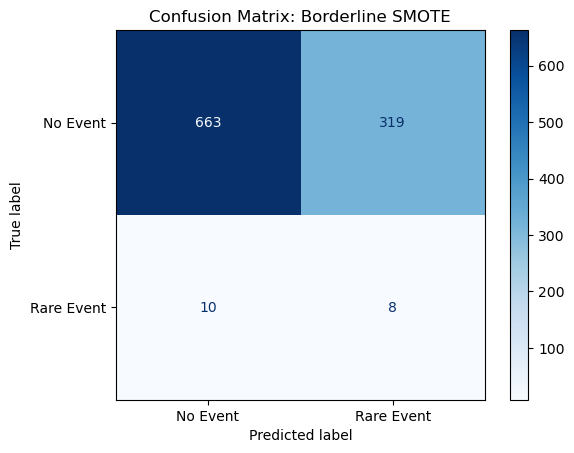

In [538]:
# BorderlineSMOTE
X_res, y_res = BorderlineSMOTE(random_state=42).fit_resample(X_train, y_train)
model = make_model()
model.fit(X_res, y_res)
evaluate_model(model, X_test, y_test, label="Borderline SMOTE")

In [540]:
model_borderline = model

## Experiment 7: Random Undersampling

--- Random UnderSampler ---
              precision    recall  f1-score   support

           0       0.98      0.53      0.69       982
           1       0.02      0.56      0.04        18

    accuracy                           0.54      1000
   macro avg       0.50      0.55      0.37      1000
weighted avg       0.97      0.54      0.68      1000

ROC AUC: 0.606
PR AUC: 0.032


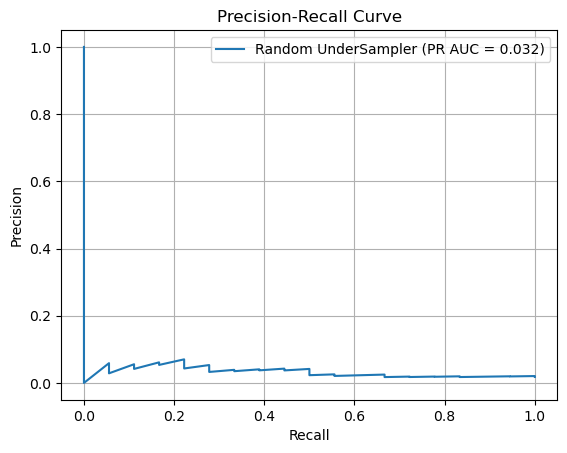

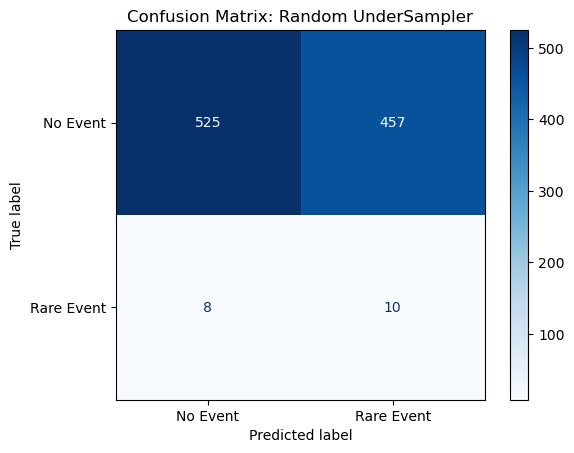

In [543]:
# Random UnderSampling
X_res, y_res = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)
model = make_model()
model.fit(X_res, y_res)
evaluate_model(model, X_test, y_test, label="Random UnderSampler")

In [545]:
model_rus = model

## Experiment 8: SMOTE + ENN

--- SMOTEENN ---
              precision    recall  f1-score   support

           0       0.99      0.57      0.73       982
           1       0.03      0.67      0.05        18

    accuracy                           0.57      1000
   macro avg       0.51      0.62      0.39      1000
weighted avg       0.97      0.57      0.71      1000

ROC AUC: 0.619
PR AUC: 0.027


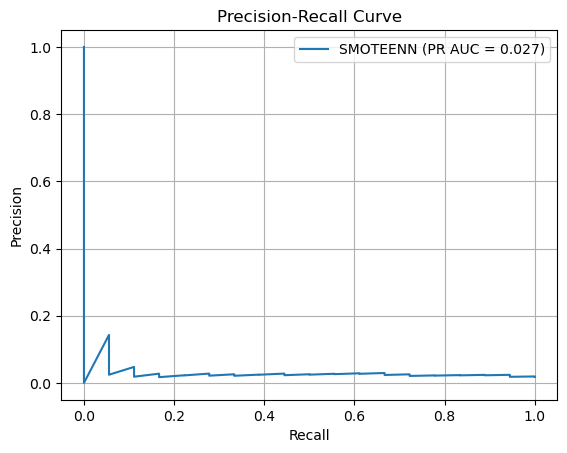

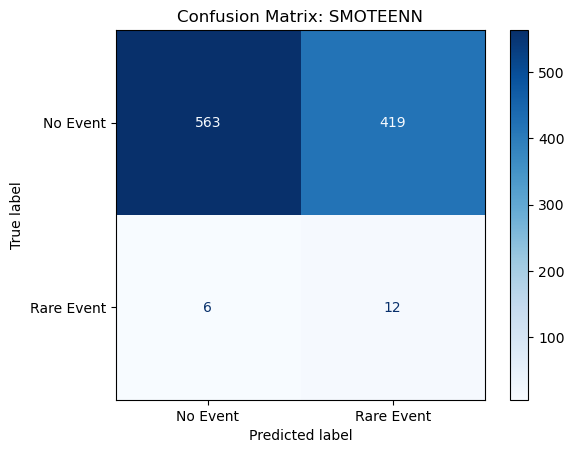

In [548]:
# SMOTEENN
X_res, y_res = SMOTEENN(random_state=42).fit_resample(X_train, y_train)
model = make_model()
model.fit(X_res, y_res)
evaluate_model(model, X_test, y_test, label="SMOTEENN")

In [549]:
model_een = model

## Experiment 9: Cluster Centroids

--- Cluster Centroids ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.639
PR AUC: 0.043


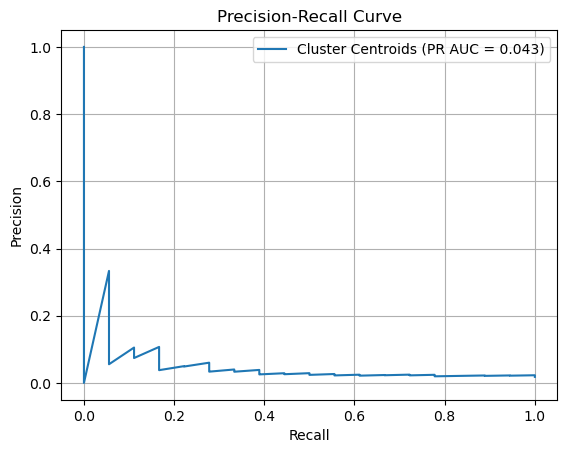

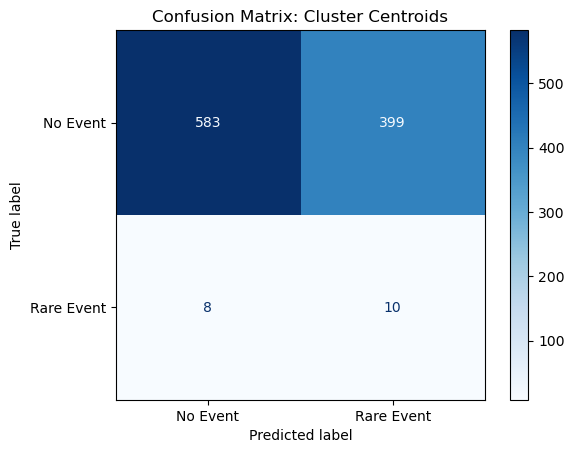

In [553]:
# Cluster Centroids
X_res, y_res = ClusterCentroids(random_state=42).fit_resample(X_train, y_train)
model = make_model()
model.fit(X_res, y_res)
evaluate_model(model, X_test, y_test, label="Cluster Centroids")

In [555]:
model_cluster = model

## Experiment 10: Balanced Bagging (ElasticNet)

--- Balanced Bagging ---
              precision    recall  f1-score   support

           0       0.98      0.55      0.70       982
           1       0.02      0.50      0.04        18

    accuracy                           0.55      1000
   macro avg       0.50      0.52      0.37      1000
weighted avg       0.97      0.55      0.69      1000

ROC AUC: 0.612
PR AUC: 0.026


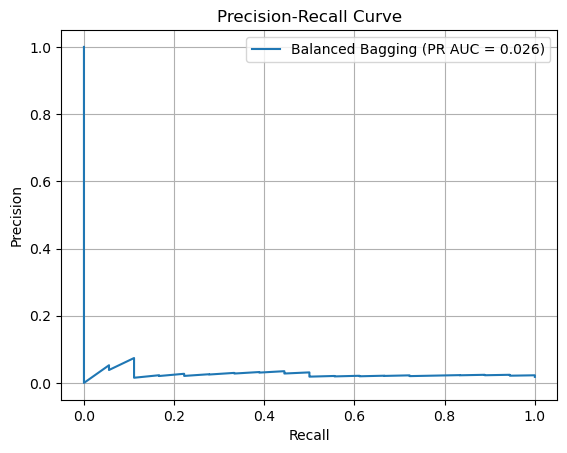

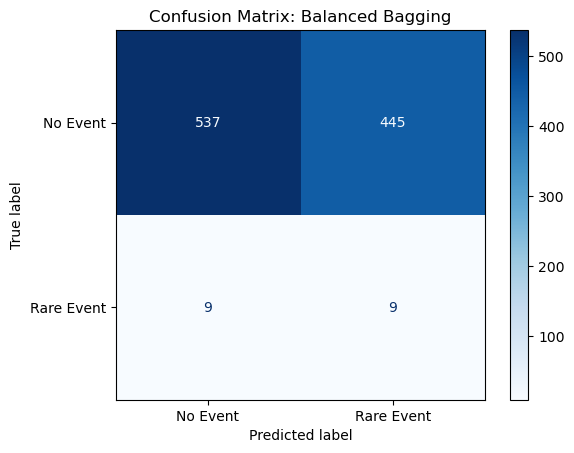

In [558]:
# Balanced Bagging
bbc = BalancedBaggingClassifier(
    estimator=make_model(),
    n_estimators=10,
    random_state=42,
    sampling_strategy='auto',
    replacement=False,
    n_jobs=-1
)
bbc.fit(X_train, y_train)
evaluate_model(bbc, X_test, y_test, label="Balanced Bagging")

In [559]:
model_bagging = model

## Final Comparison
Visualize and compare all PR AUC and ROC AUC scores.

In [563]:
# Final Comparison
comparison_df = pd.DataFrame(results).sort_values("PR AUC", ascending=False)

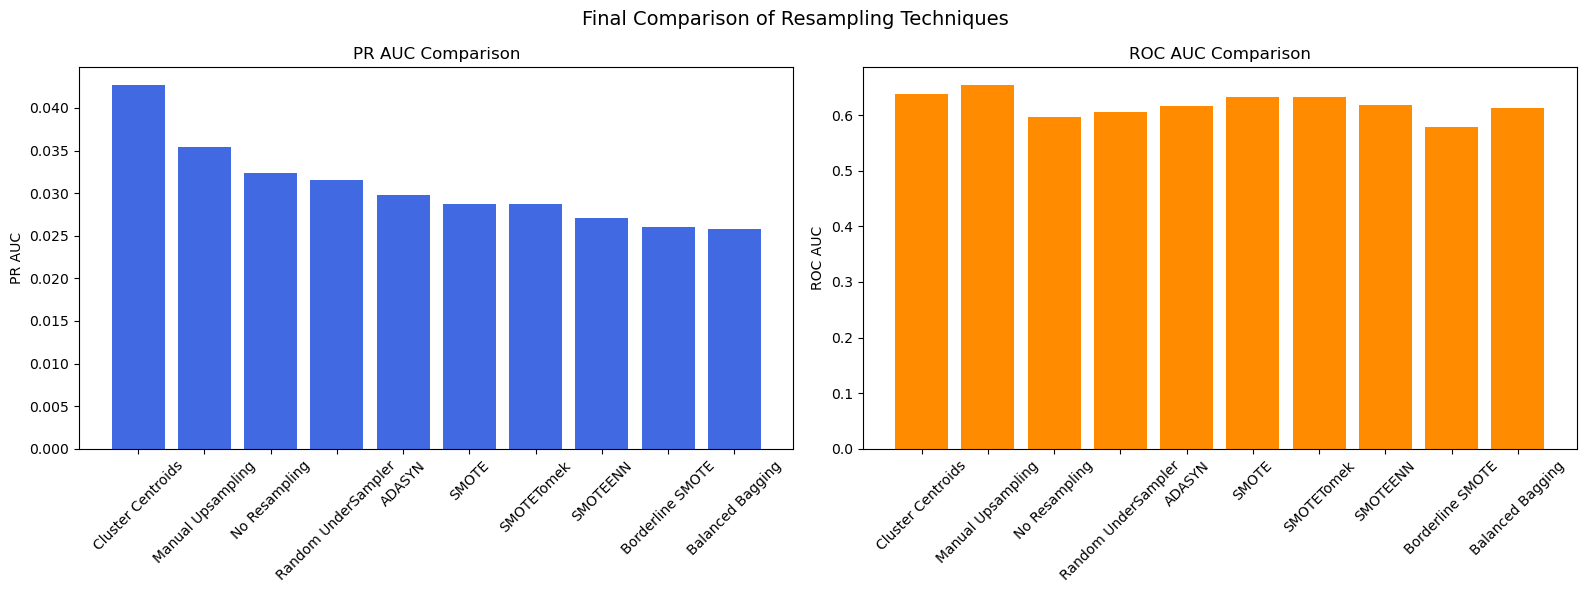

In [565]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# PR AUC
axs[0].bar(comparison_df["Method"], comparison_df["PR AUC"], color='royalblue')
axs[0].set_title("PR AUC Comparison")
axs[0].set_ylabel("PR AUC")
axs[0].tick_params(axis='x', rotation=45)

# ROC AUC
axs[1].bar(comparison_df["Method"], comparison_df["ROC AUC"], color='darkorange')
axs[1].set_title("ROC AUC Comparison")
axs[1].set_ylabel("ROC AUC")
axs[1].tick_params(axis='x', rotation=45)

plt.suptitle("Final Comparison of Resampling Techniques", fontsize=14)
plt.tight_layout()
plt.show()

In [567]:
# Sort by PR AUC descending
display(comparison_df.sort_values("PR AUC", ascending=False).reset_index(drop=True))

,Method,ROC AUC,PR AUC
0,Cluster Centroids,0.638549,0.042639
1,Manual Upsampling,0.653315,0.035408
2,No Resampling,0.597533,0.032336
3,Random UnderSampler,0.605906,0.031565
4,ADASYN,0.616655,0.029730
5,SMOTE,0.631987,0.028748
6,SMOTETomek,0.631987,0.028748
7,SMOTEENN,0.618805,0.027132
8,Borderline SMOTE,0.578977,0.026059
9,Balanced Bagging,0.611960,0.025772


In [569]:
def evaluate_model(model, X_test, y_test, label=""):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"--- {label} ---")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    print("PR AUC:", round(pr_auc, 3))

    # PR Curve
    plt.plot(recall, precision, label=f"{label} (PR AUC = {pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Event", "Rare Event"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix: {label}")
    plt.grid(False)
    plt.show()

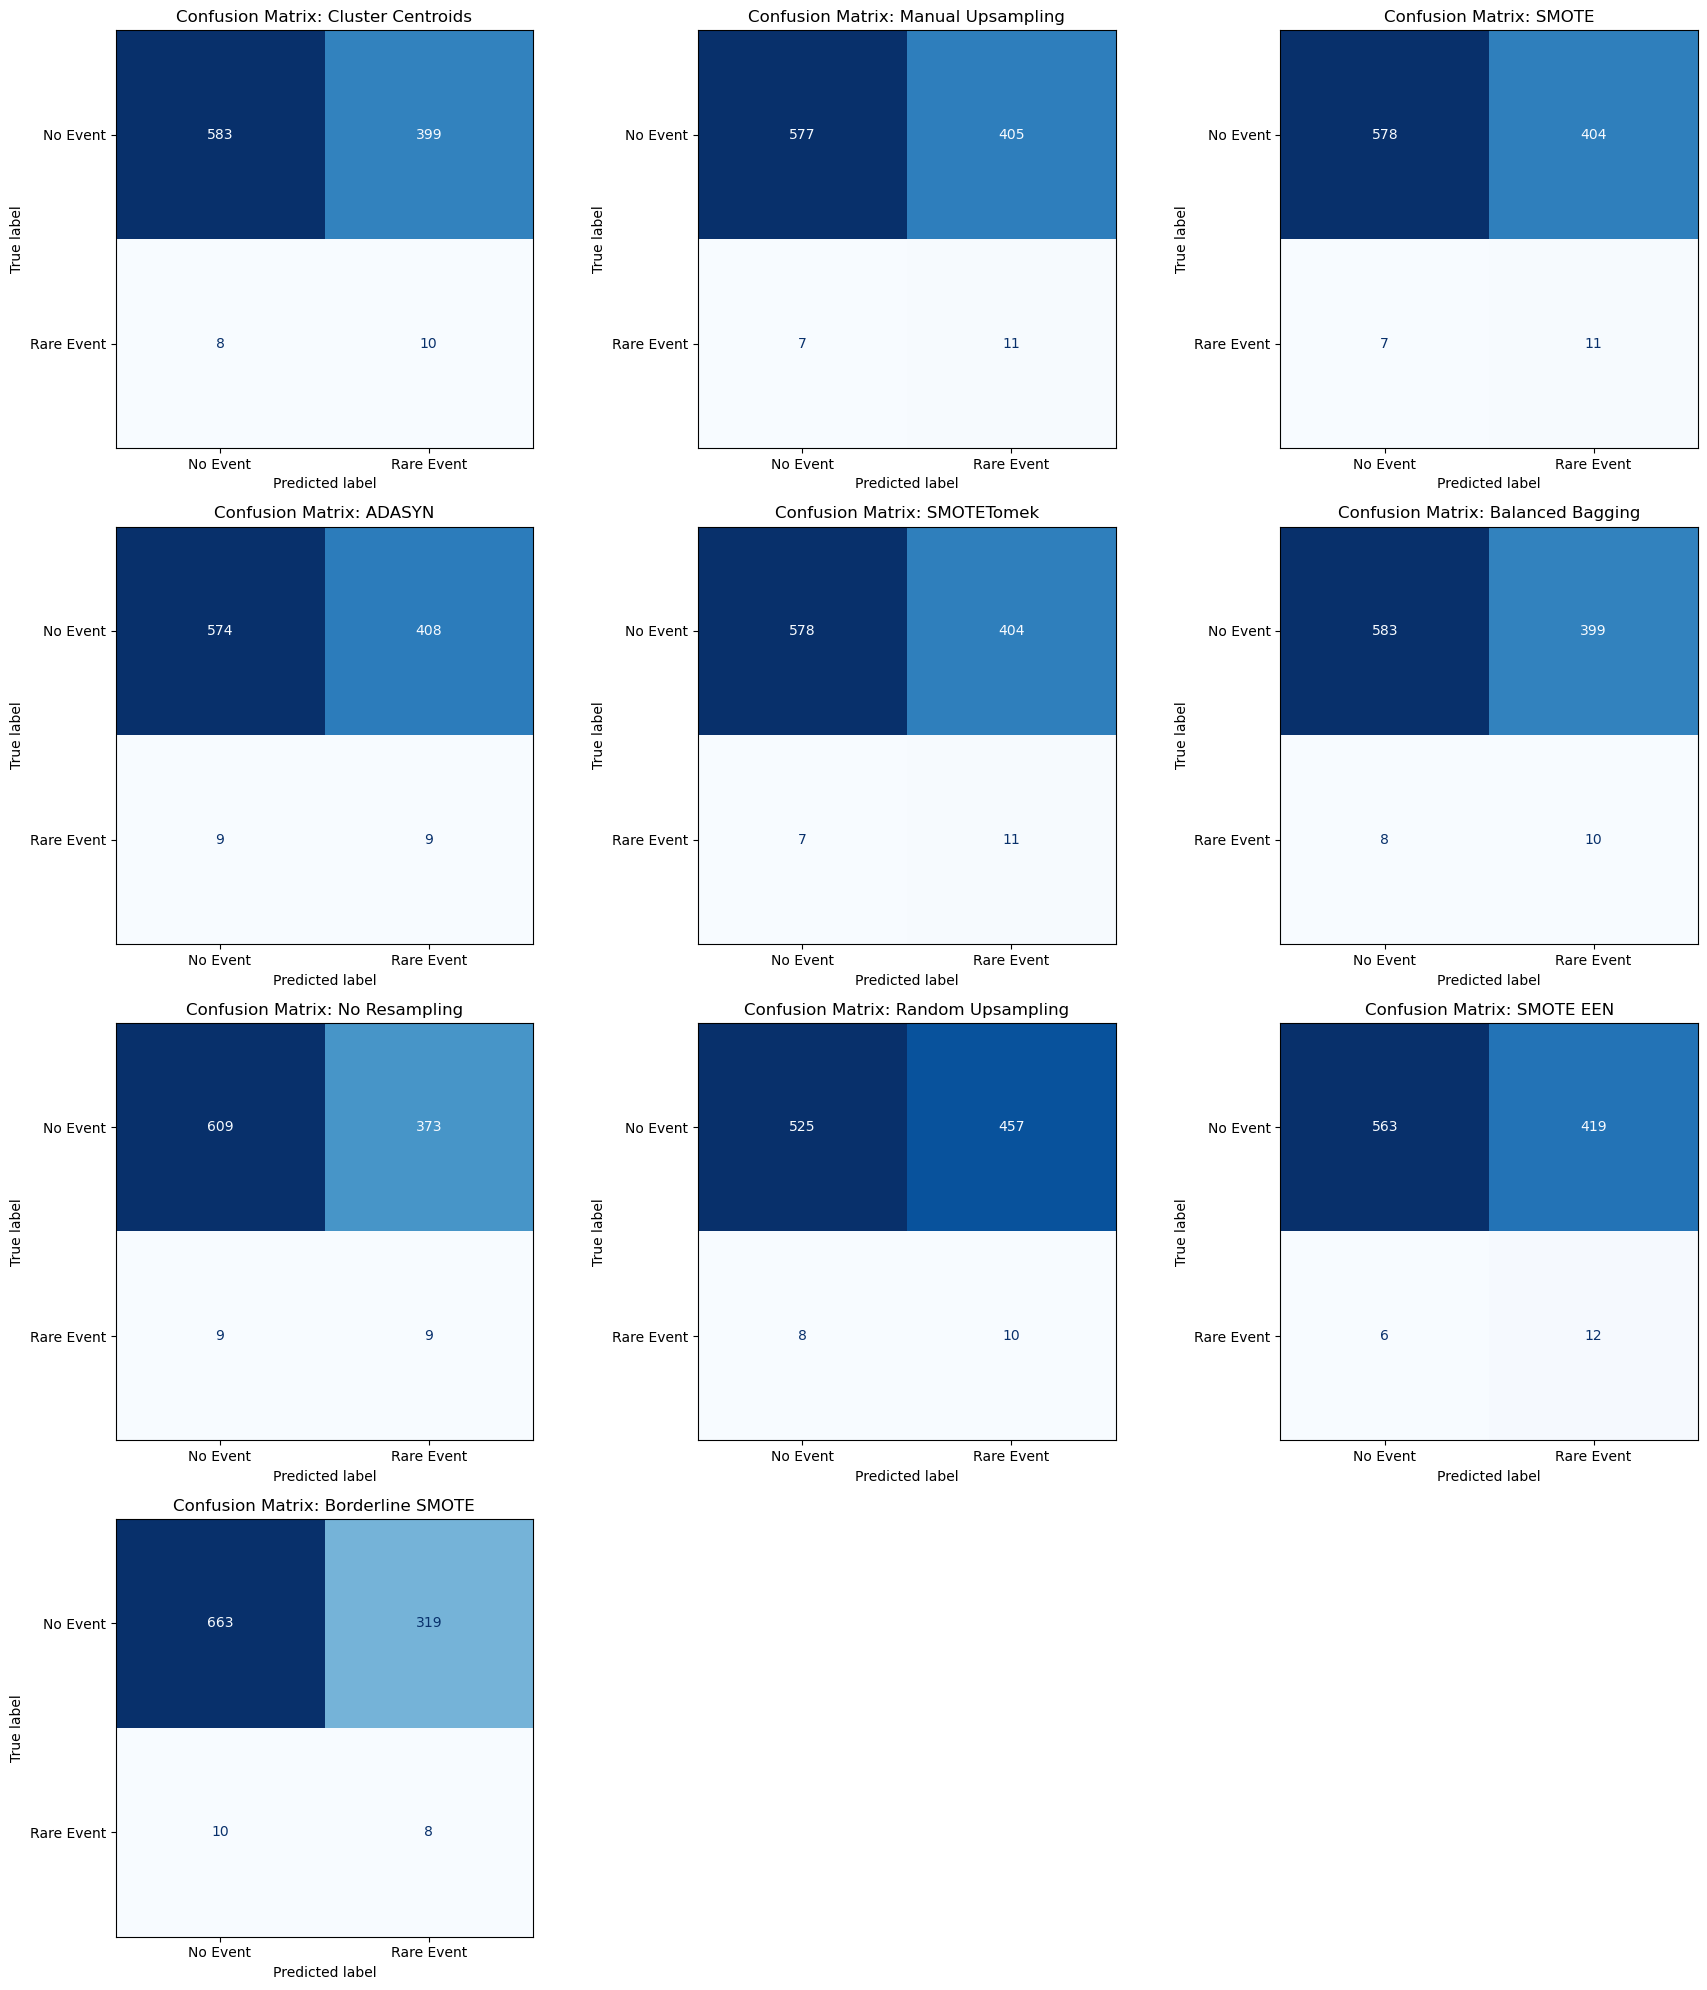

In [571]:
# List of trained models and their labels
models = [
    ("Cluster Centroids", model_cluster),
    ("Manual Upsampling", model_manual),
    ("SMOTE", model_smote),
    ("ADASYN", model_adasyn),
    ("SMOTETomek", model_tomek),
    ("Balanced Bagging", model_bagging),
    ("No Resampling", model_baseline),
    ("Random Upsampling", model_rus),
    ("SMOTE EEN", model_een),
    ("Borderline SMOTE", model_borderline)
    # Add more if you've trained more models
]

# Ground truth (same for all)
y_true = y_test

# Plot configuration
n_cols = 3
n_rows = int(np.ceil(len(models) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))

for i, (label, model) in enumerate(models):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(cm, display_labels=["No Event", "Rare Event"])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f"Confusion Matrix: {label}")

# Hide empty plots if model count doesn't fill grid
for j in range(i + 1, n_rows * n_cols):
    row = j // n_cols
    col = j % n_cols
    fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

plt.tight_layout()
plt.show()